# **Analisi dei dati di rete in una comunità di musicisti Jazz**

vedere il file README.md per Obiettivi, metologia e altre informazioni

In [95]:
# importo le librerie
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import networkx as nx
import seaborn as sb
import requests as rq
import pickle
import itertools
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil
from scipy import stats
from networkx.algorithms import community

### scraping dei dati

In [3]:
# SCRAPE_DATA = True => esegue lo scraping dei dati dal sito 
#             = False => carica i dati dal file .pickle senza eseguire un nuovo scraping 
SCRAPE_DATA = False

if SCRAPE_DATA:
    base_url = "https://www.jazzdisco.org"
    soup = BeautifulSoup(rq.get(base_url).content)

    # estrae i nomi dei musicisti dalla pagina principale ed il relativo link alla pagina del catalogo
    def scan_main(init_link):
        for li in init_link.find_all("li"):
            cat_link = base_url+li.find("a")["href"]+"catalog/" # link al catalogo
            scrape_catalog(cat_link, album_pers) # chiama la funzione di scraping del catalogo

    # esegue lo scraping della pagina del catalogo
    def scrape_catalog(link, target_list):
        print("scraping: ", link)
        link_soup = BeautifulSoup(rq.get(link).content)
        p_list = link_soup.find_all("p", {'class': None, "id": None})
        for p in p_list:
            text = p.text.strip()
            text = text.replace("same session.", "")
            if text != "same personnel." and text[:2] != "**" and text != "":
                target_list.append(text) # aggiunge alla lista il personnel di ogni singolo album (come unica stringa)
        
        return

    #la lista dei musicisti è divisa in due div con una struttura leggermente diversa
    div1 = soup.find_all("div", {'class': 'first-box'})
    div2 = soup.find_all("div", {'class': 'second-box'})
    root_link1 = div1[0]
    root_link2 = div2[0].find("ul")

    album_pers = [] # lista che conterrà le stringhe con i personnel di ogni album
    for r in [root_link1, root_link2]:
        scan_main(r)

    # alcune correzioni:
    # record 12952: correggere , Archie con ; Archie
    # album_pers[12952] = album_pers[12952].replace(", Archie", "; Archie")
    # errore alla posizione 12691: correggere Gary Plummley, Pharoah Sanders con Pharoah Sanders, Gary Plummley
    # album_pers[12691] = album_pers[12691].replace("Gary Plummley, Pharoah Sanders", "Pharoah Sanders, Gary Plummley")
    # errore alla posizione 10860: correggere Robert Merchez, Charlie Parker con Charlie Parker, Robert Merchez
    # album_pers[10860] = album_pers[10860].replace("Robert Merchez, Charlie Parker", "Charlie Parker, Robert Merchez")

    # salviamo la lista per non dover scaricare di nuovo dal sito in futuro
    pickle.dump(album_pers, open( "album_pers.pickle", "wb" ) )
else:
    album_pers = pickle.load( open("album_pers.pickle",'rb') )

In [4]:
# ora è necessario scomporre tutti i personell nei singoli musicisti
# e rifinire i nomi eliminando alcuni testi aggintivi

In [5]:
def clean_names(name, pattern):
    result = re.search(pattern, name, flags=re.I)  
    if result is not None:
        name = result.group(1)       
    return name

In [6]:
album_musicians = []
for e in album_pers:
    
    split1 = e.split(";") # prima splitto al ;

    names = [n[0].strip() for n in [n.split(",") for n in split1]] #splitto alla virgola e prendo la prima stringa (restituisce il nome)
    names_cleaned = []    

    #rifinisco la lista togliendo alcuni pattern indesiderati
    
    for i, name in enumerate(names):
        pattern_list = [
                r'\+ (.+)',  # rimuovo il pattern +<blank>
                r'.+: (.+)', # pattern ...:
                r'(.+) as .+', # pattern <blank>as<blank>...
                r'with (.+)',   # pattern with<blank>
                r'(.+) or .+',   # pattern ...<blank>or<blank>...
                r'possibily (.+)', # pattern possibily<blank>
                r'probably (.+)', # pattern probably<blank>
                r'featuring (.+)', # pattern featuring<blank>
            ]
        for pattern in pattern_list:
            name = clean_names(name, pattern)
                            
        name = name.title().replace('"','')

        # infine controllo alcuni pattern che non rappresentano nuovi nomi
    
        if not name.startswith("Replaces") and \
           not name.startswith("Omit") and \
           not name.startswith("Unknown") and \
           not name.startswith("Unidentified") and \
           not name in (names_cleaned): # questa condizione evita i casi in cui lo stesso musicista è citato due volte nella formazione
            names_cleaned.append(name)
    
    # appendo alla lista finale
    # solo se la lunghezza della formazione è almeno di due musicisti
    # e se la formazione non è già presente nella lista finale 
    if len(names_cleaned) > 1 and names_cleaned not in album_musicians: 
        album_musicians.append(names_cleaned)

In [7]:
# elenco dei musicisti (saranno i nodi del grafo)

musicians = set()
for a in album_musicians:
    musicians.update(a)
musicians = list(musicians)


In [8]:
# ora costruiamo tutte le coppie per ogni album

In [9]:
def create_couples(album, target_list):
    for couple in itertools.combinations(album, 2):
        rev_couple = (couple[1], couple[0])
        if (not couple in target_list) and (not rev_couple in target_list):
            target_list.append(couple)

    return

In [10]:
# lista che conterrà tutte le coppie (saranno gli spigoli del grafo)
edges_list = []
from IPython.display import clear_output
i = 0
for album in album_musicians:
    i+=1
    if i%100 == 0:
        clear_output(wait=True)
        print("album #:", i, " di ", str(len(album_musicians)))
    create_couples(album, edges_list)

album #: 6600  di  6671


## alcune misure di sintesi

In [11]:
print('Numero di musicisti: {:5d}'.format(len(musicians)))
print('Numero di formazioni: {:5d}'.format(len(album_musicians)))

Numero di musicisti:  6596
Numero di formazioni:  6671


Misure di sintesi delle incisioni:


Min #musicisti:     2
Max #musicisti:    28
Media:     5
Mediana:     5
Moda:     5
DevStd:   2.76




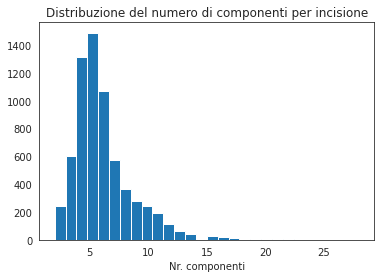

In [12]:
album_lengths = [len(x) for x in album_musicians]
print('Misure di sintesi delle incisioni:')
print('\n')
print('Min #musicisti: {:5d}'.format(min(album_lengths)))
print('Max #musicisti: {:5d}'.format(max(album_lengths)))
print('Media: {:5d}'.format(int(np.mean(album_lengths))))
print('Mediana: {:5d}'.format(int(np.median(album_lengths))))
print('Moda: {:5d}'.format(int(stats.mode(album_lengths).mode[0])))
print('DevStd: {:6.2f}'.format(np.std(album_lengths)))
print('\n')
with sb.axes_style("white"):
    plt.hist(album_lengths, bins=28)
    plt.title("Distribuzione del numero di componenti per incisione")
    plt.xlabel("Nr. componenti")



## Creazione del grafo

In [13]:
G = nx.Graph()
G.add_edges_from(edges_list)

### Inizio analisi dei dati del grafo completo

In [14]:
# misure di sintesi

print("Numero di nodi: {:5d}".format(G.number_of_nodes()) )
print("Numero di spigoli: {:5d}".format(G.number_of_edges()) )
print("Densità: {:06.5f}".format(nx.density(G)) )
print("Diametro: {:5d}".format(nx.diameter(G)) )
print("Numero di componenti: {:5d}".format(nx.number_connected_components(G)) )



Numero di nodi:  6596
Numero di spigoli: 70653
Densità: 0.00325
Diametro:     6
Numero di componenti:     1


In [15]:
# Analisi della centralità

# calcoliamo le seguenti misure:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
between_centrality = nx.betweenness_centrality(G)
eigen_centrality = nx.eigenvector_centrality(G)
neighbours = dict(G.degree())

In [16]:
# trasforminamo le misure in un data frame indicizzato sui musicisti:

In [17]:
centrality_df = pd.DataFrame(zip(neighbours.keys(), 
                                 neighbours.values(), 
                                 degree_centrality.values(), 
                                 closeness_centrality.values(), 
                                 between_centrality.values(),
                                 eigen_centrality.values()),
                             columns=["Musician", 
                                      "Neighbours",
                                      "Degree",
                                      "Closeness",
                                      "Betweenness",
                                      "Eigenvector"]
                            ).set_index("Musician")

In [18]:
# e salviamo il data frame per non dover più eseguire i calcoli di centralità
centrality_df.to_pickle("centrality_df.pickle")

In [19]:
#misure di sintesi sul df
centrality_df.describe()

,Neighbours,Degree,Closeness,Betweenness,Eigenvector
count,6596.000000,6596.000000,6596.000000,6596.000000,6596.000000
mean,21.422984,0.003248,0.330367,0.000311,0.005203
std,41.347658,0.006270,0.031635,0.002173,0.011161
min,1.000000,0.000152,0.219220,0.000000,0.000002
25%,6.000000,0.000910,0.310660,0.000000,0.000863
50%,10.000000,0.001516,0.327125,0.000000,0.001772
75%,19.000000,0.002881,0.345777,0.000025,0.004288
max,634.000000,0.096133,0.500379,0.068820,0.137994


In [20]:
# visualizziamo i musicisti con il maggior numero di legami
centrality_df.sort_values("Neighbours", ascending=False).head(20)

,Neighbours,Degree,Closeness,Betweenness,Eigenvector
Musician,,,,,
Ron Carter,634,0.096133,0.500379,0.039131,0.137994
Stan Getz,523,0.079303,0.466704,0.045684,0.087533
Dizzy Gillespie,499,0.075663,0.458942,0.037278,0.091382
Tommy Flanagan,481,0.072934,0.470668,0.026548,0.115352
Chet Baker,476,0.072176,0.446423,0.068820,0.048035
Joe Henderson,464,0.070356,0.445037,0.029744,0.076354
Miles Davis,458,0.069447,0.464469,0.033203,0.089478
Elvin Jones,441,0.066869,0.473813,0.031526,0.097441
Zoot Sims,433,0.065656,0.453514,0.024345,0.092825


In [21]:
# grafico dei primi 20 musicisti in base alle misure di centralità

In [22]:
def extract_top(df, column, threshold=20):
    return df.sort_values(column, ascending=False)[column].head(threshold)

def plot_centrality(df, cols, threshold=20, rescale=False):
    
    sb.set()
    fig, axes = plt.subplots(nrows=1,ncols=len(cols), figsize=(len(cols)*5,10))
    
    for i, c in enumerate(cols):
        s = extract_top(df, c, threshold)
       
        #rescaling opzionale:
        if rescale:
            s = (s - min(s))/(max(s) - min(s))
        
        if len(cols)>1:
            obj = axes[i]
        else:
            obj = axes
        obj.barh(s.index, s)
        obj.set_title(c)

    plt.subplots_adjust(wspace=0.90)



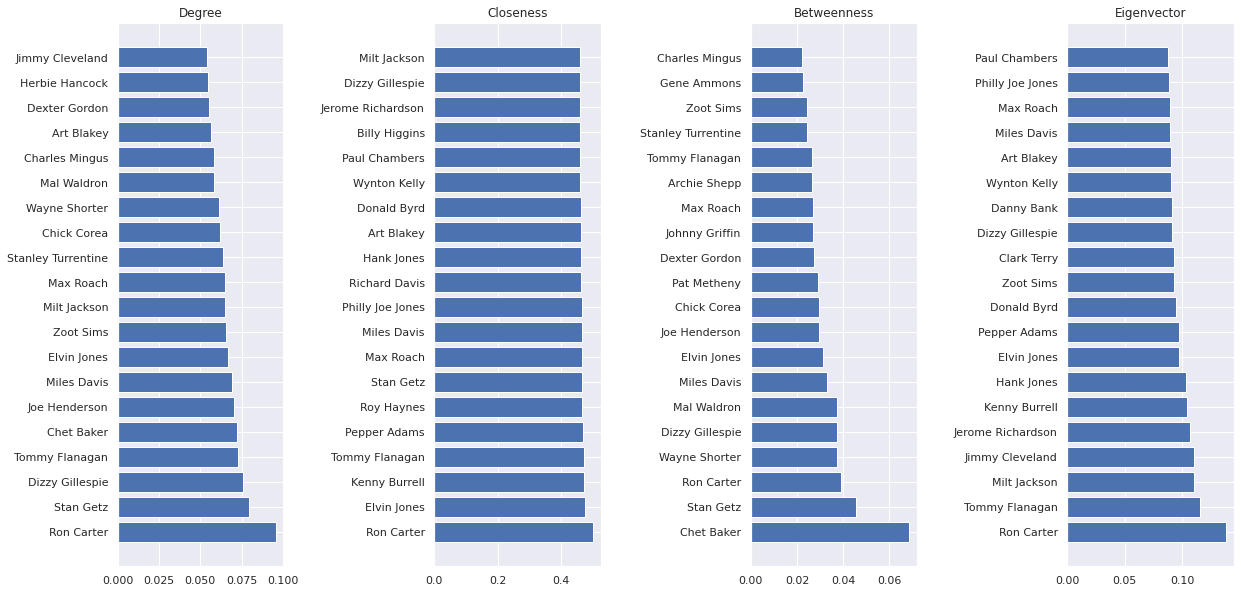

In [23]:
plot_centrality(centrality_df, ["Degree", "Closeness", "Betweenness", "Eigenvector"], 20, False)

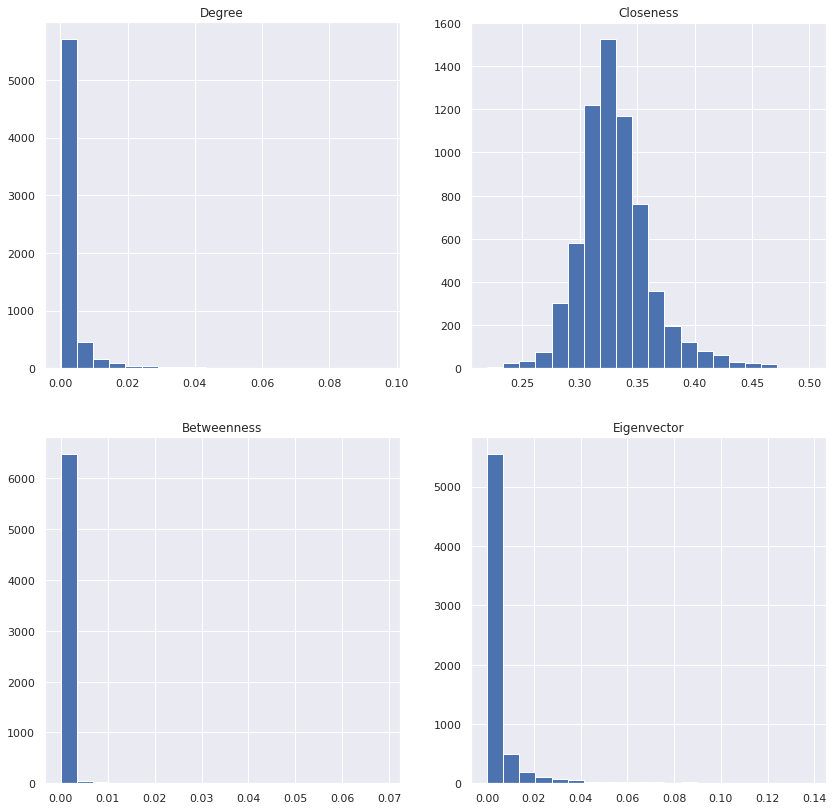

In [24]:
# distribuzione delle misure di centralità
def dist_centrality(df, cols, bins=20):
    grid_dims = ceil(len(cols)/2)
    sb.set()
    fig, axes = plt.subplots(nrows=grid_dims, ncols=grid_dims, figsize=(grid_dims*7,grid_dims*7))
    for i, c in enumerate(cols):
        x = i // grid_dims
        y = i % grid_dims 
        axes[x,y].hist(df[c], bins=bins)
        axes[x,y].set_title(c)

dist_centrality(centrality_df, ["Degree", "Closeness", "Betweenness", "Eigenvector"])

## Costruiamo una misura di sintesi e visualizziamo i primi 20 musicisti

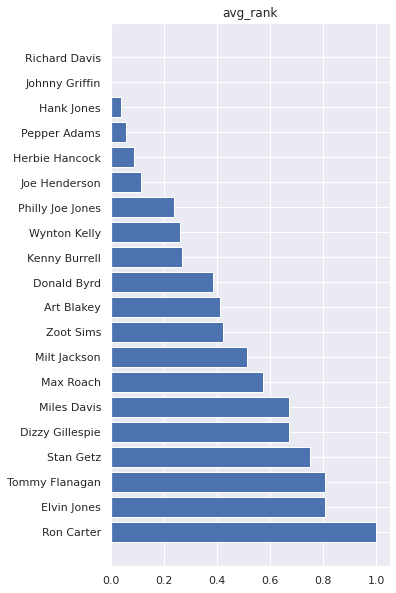

In [25]:
centrality_df = pickle.load(open("centrality_df.pickle", "rb"))

rank_df = pd.DataFrame()
for c in centrality_df.loc[:,"Degree":"Eigenvector"].columns:
    rank_df[c] = centrality_df[c].rank()

rank_df['avg_rank'] = rank_df.mean(axis=1)

rank_df["avg_rank"].sort_values( ascending=False).head(20)

plot_centrality(rank_df, ["avg_rank"], 20, rescale=True)

## **Individuazione dei componenti connessi**
### Applichiamo iterativamente l'Island method per ridurre il numero di nodi escludendo 
### progressivamente i musicisti con minor numero di legami


### obiettivo: verificare se iniziano gradualmente a crearsi dei componenti connessi

In [26]:
def create_subgraph(G, n):
    S = nx.Graph()
    deg_dict = dict(G.degree())
    filtered = list(
        dict(
            filter(lambda d:d[1]>n, deg_dict.items())
        ).keys()
    )
    S = G.subgraph(filtered)
    
    return S


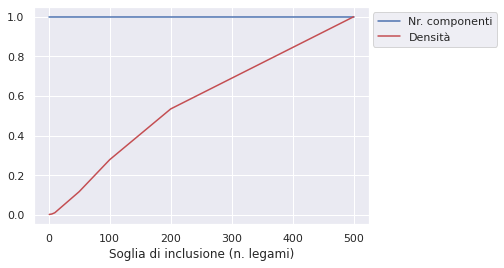

In [27]:
num_components_dict = dict()
density_dict = dict()
for n in [1, 5, 10, 50, 100, 200, 500]:
    S = create_subgraph(G, n)
    num_components_dict[n] = nx.number_connected_components(S)
    density_dict[n] = nx.density(S)

plt.plot(num_components_dict.keys(), num_components_dict.values(), c='b', label='Nr. componenti');
plt.plot(num_components_dict.keys(), density_dict.values(), c='r', label='Densità');
plt.xlabel("Soglia di inclusione (n. legami)");
plt.legend(loc='upper right', bbox_to_anchor=(1.4,1));

*Conclusione:* la rete risulta sempre composta da un unico componente, indipendentemente da eventuali 
esclusioni dei musicisti meno connessi

com'è logico attendersi, la densità della rete invece aumenta progressivamente  

## **Analisi di sottografi, comunità e clusters**

### la ricerca delle cliques non ha senso con questo dataset, in quanto porterebbe necessariamente
### ad evidenziare le singole incisioni come cliques, portando in evidenza le incisioni orchestrali come 
### cliques più numerose

## **ego-graph selettivi**

### iniziamo con i musicisti con il rango medio maggiore nella classifica delle misure di centralità,
### aggiungendo Chet Baker che sembra avere una struttura particolare

,Nodes,Density,Clustering
Ron Carter,635.0,0.063211,0.609749
Elvin Jones,442.0,0.066026,0.616645
Stan Getz,524.0,0.045984,0.643291
Tommy Flanagan,482.0,0.071997,0.594222
Dizzy Gillespie,500.0,0.055415,0.668853
Chet Baker,477.0,0.030504,0.721704


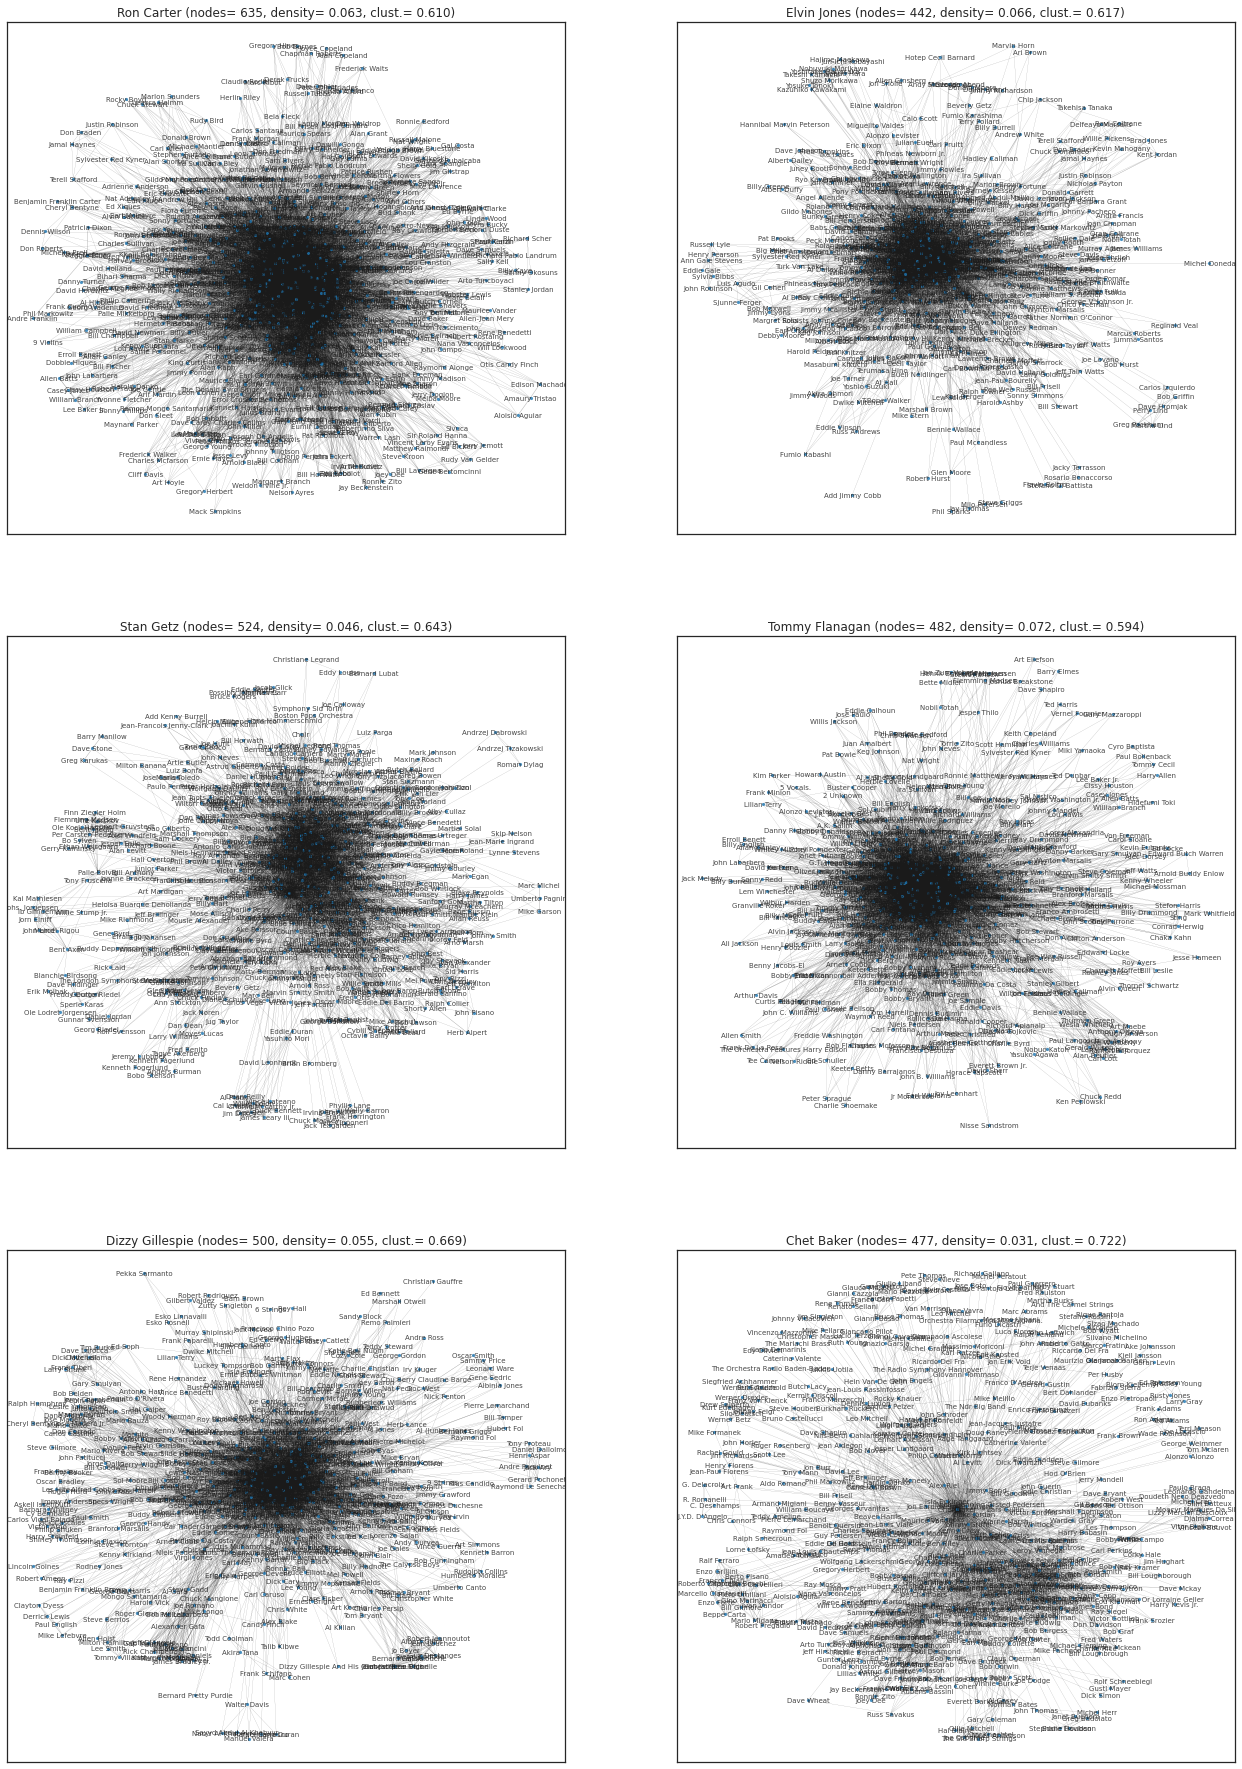

In [28]:
centers = ["Ron Carter", "Elvin Jones", "Stan Getz", "Tommy Flanagan", "Dizzy Gillespie", "Chet Baker"]
R = 1
egos_dict = dict()
sb.set_theme(style='white')
fig=plt.figure(figsize=(22,32))
for i, c in enumerate(centers):
    ego = nx.Graph(nx.ego_graph(G, c, radius=R))
    n_n = ego.number_of_nodes()
    den = nx.density(ego)
    a_c = nx.average_clustering(ego)
    egos_dict[c] = [n_n, den, a_c]
    ax=plt.subplot(3,2,i+1)
    options = {
        "with_labels": True,
        "node_size": 10, 
        "linewidths": 0.0, 
        "width": 0.1, 
        "alpha": 0.8,
        "font_size": 7
    }
    nx.draw_networkx(ego,ax=ax, **options)
    ax.set_title('{} (nodes={:4d}, density={:6.3f}, clust.={:6.3f})'.format(c, n_n, den, a_c))
    

egos_df = pd.DataFrame(egos_dict).transpose().rename({0: 'Nodes', 1: 'Density', 2: 'Clustering'}, axis=1)
egos_df

## **Visualizzazione grafica**
#### iniziamo con il tracciamento del grafo completo, benchè poco leggibile vista la numerositì dei nodi


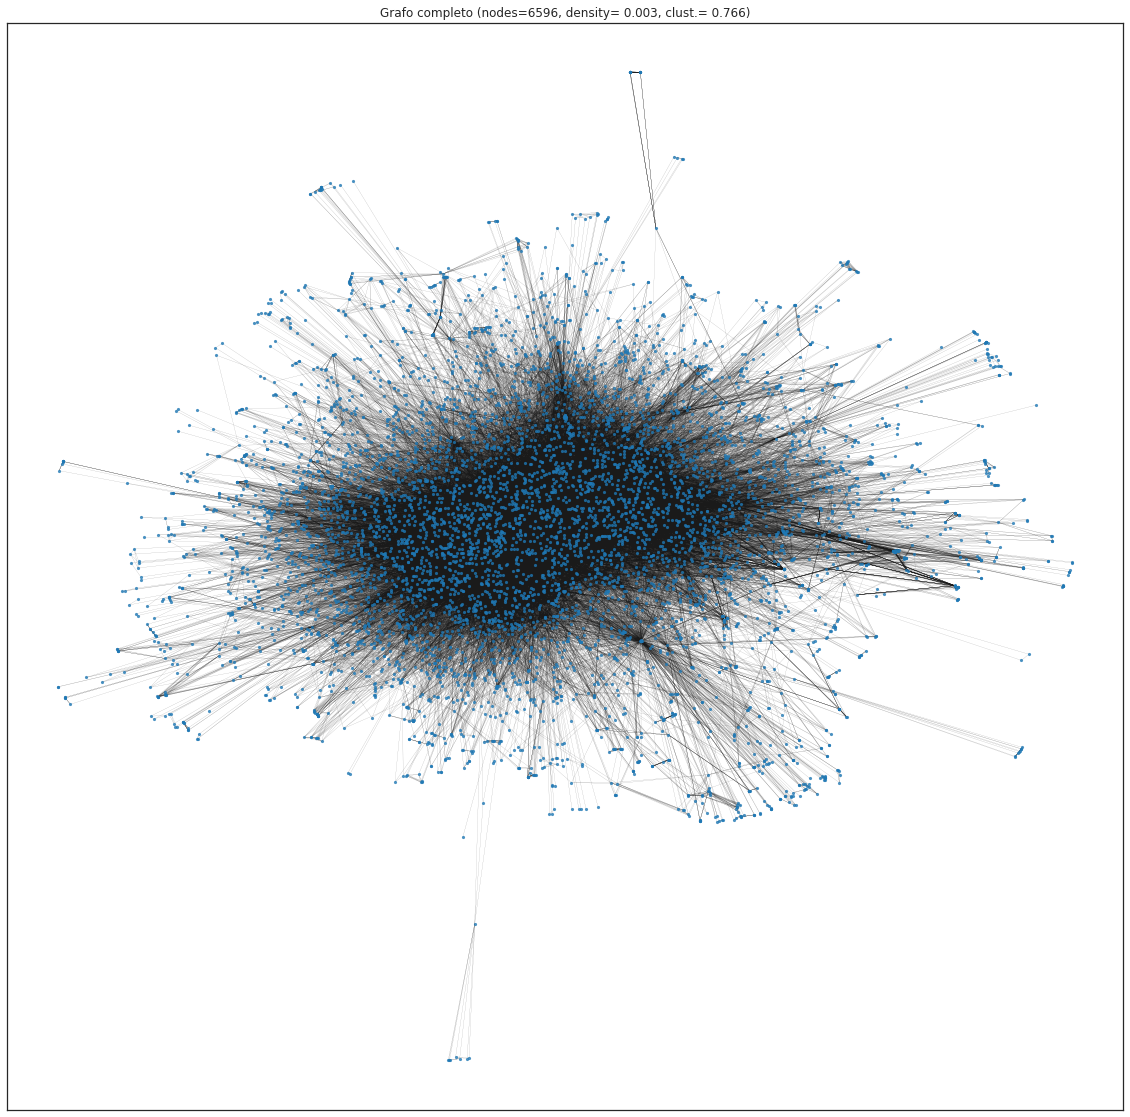

In [107]:
# iniziamo comunque a tracciare il grafico completo

with sb.axes_style("white"):
    plt.figure(figsize=(20,20))
    options = {
        "with_labels": False,
        "node_size": 10, 
        "linewidths": 0.0, 
        "width": 0.1, 
        "alpha": 0.8
    }
    nx.draw_networkx(G,  **options)
    plt.title('Grafo completo (nodes={:4d}, density={:6.3f}, clust.={:6.3f})'.format(G.number_of_nodes(), nx.density(G), nx.average_clustering(G)))


#### ora visualizziamo il sottografo indotto dai 20 musicisti con maggior rango medio

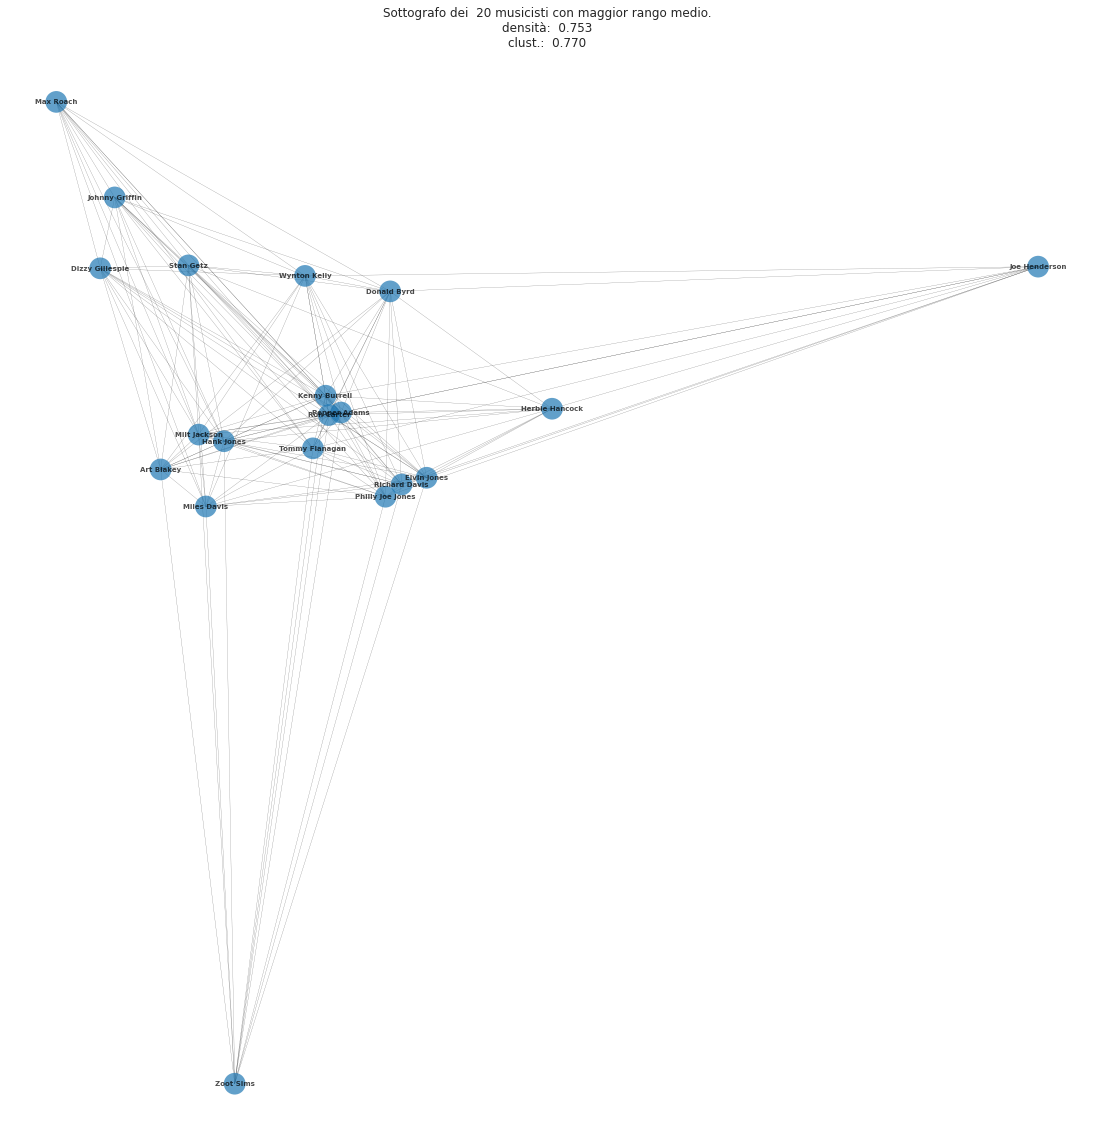

In [30]:


# seleziono la lista degli N musicisti con almeno un certo numero di collegamenti e costruisco il loro sotto-grafo
N = 20
top_N = list(rank_df.sort_values("avg_rank", ascending=False).head(N).index)
S = nx.subgraph(G, top_N)

# # lista delle dimensioni
SCALE=1.0
nodes_dim = rank_df.loc[top_N,"avg_rank"].apply(lambda x:x**SCALE).to_list()



# tracciamento del grafo

plt.figure(figsize=(15,15))
options = {
    "with_labels": True,
    "font_size": 7, 
    "font_color": "black", 
    "font_weight": "bold",
    "linewidths": 0.0, 
    "width": 0.2, 
    "alpha": 0.7,
    "node_size": nodes_dim
}
#nx.draw_networkx(S,  **options)
nx.draw_spectral(S,  **options)
plt.title("Sottografo dei {:3d} musicisti con maggior rango medio.\ndensità: {:6.3f}\nclust.: {:6.3f}".format(N, nx.density(S), nx.average_clustering(S)))
plt.show()

nx.write_graphml(S, "top_N.graphml")

### Analisi delle comunità 

In [99]:
# utilizziamo l'algoritmo di massimizzazione della modularità di Clauset-Newman-Moore 
cnm_partition = community.greedy_modularity_communities(G) #Clauset-Newman-Moore

print("Nr. di partizioni: {:3d} - modularità: {:6.3f}".format(len(cnm_partition), community.modularity(G, cnm_partition)))

Nr. di partizioni: 121 - modularità:  0.401


#### la modularità della rete è modesta e il numero di partizioni abbastanza elevato, ma può esserci spazio per qualche risultato

#### individuiamo i *centri* delle comunità, costruendo i sottografi indotti ed il nodo con grado massimo per ogni sottografo
#### infine visualizziamo le comunità più estese con i relativi centri

In [100]:
communities_df = pd.DataFrame(columns=["Center", "Nodes", "Density"])
for i, c in enumerate(cnm_partition):
    c_nodes = list(cnm_partition[i])
    C = nx.subgraph(G, c_nodes)
    density = nx.density(C)
    n_nodes = C.number_of_nodes()
    degrees = C.degree()
    center = pd.DataFrame(C.degree()).sort_values(1, ascending=False).head(1)[0].values[0] #definiamo "centro" della comunità il nodo di grado più alto
    row_to_app = {"Center": center, "Nodes": n_nodes, "Density": density}
    communities_df = communities_df.append(row_to_app, ignore_index=True)

### le comunità più estese

communities_df.sort_values("Nodes", ascending=False).head()

,Center,Nodes,Density
0,Ron Carter,1959,0.013594
1,Charlie Parker,1951,0.007785
2,Archie Shepp,1136,0.008409
3,Mal Waldron,249,0.028177
4,Dave Brubeck,229,0.033824
